# Ghost Job Feature Framework




Proposed by Hiram Dominguez from the University of North Texas

Advised by Hadiseh Gooran

Link to [official academic work](https://docs.google.com/document/d/1lgGbkDKvrhyGfhmyij2xtaNTgYWtkt0g/edit?usp=sharing&ouid=111604924284039846725&rtpof=true&sd=true)

#Introduction

This notebook is dedicated on displaying accuracy results on detecting ghost jobs by adding these three features into any dataset such as Kaggle Fake and Real Jobs, EMSCAD, etc:


*   Company stock prices using the yfinance library
*   Layoff rates using Layoff.fyi
*   Job reposts made by the same company through manual implementation

These features will be trained and tested with BERT, Bi-LTSM, and other traditional NLP models.




#Training and Testing Methology

The listed features will be programmed on different cells inorder, then each dataset will be cleaned and ready to be trained and tested on the following ML models:


1.   BERT
2.   LTSM
3.   Traditional NLP techniques

These models will be programmed based on common programming practices that will be credited. After each testing cell there will be a graph testing ghost job accuracy and ROC.





# Framework Setup

In [ ]:
#Dataframe 'df' variable declaration
import pandas as pd
#Put in any csv file like Google Jobs, BD Jobs, EMSCAD, etc.
df = pd.read_csv("fake_job_postings.csv")
df = df.sample(n=750, random_state=42)

## Stock Prices

In [ ]:
import yfinance as yf

#Tech company name-to-ticker mapping
tech_ticker_map = {
    "Google": "GOOG",
    "Alphabet": "GOOG",
    "YouTube": "GOOG",
    "Meta": "META",
    "Facebook": "META",
    "Instagram": "META",
    "Amazon": "AMZN",
    "AWS": "AMZN",
    "Twitch": "AMZN",
    "Microsoft": "MSFT",
    "LinkedIn": "MSFT",
    "Apple": "AAPL",
    "Tesla": "TSLA",
    "SpaceX": "TSLA",
    "Netflix": "NFLX",
    "NVIDIA": "NVDA",
    "Intel": "INTC",
    "AMD": "AMD",
    "IBM": "IBM",
    "Salesforce": "CRM",
    "Oracle": "ORCL",
    "Adobe": "ADBE",
    "Spotify": "SPOT",
    "Zoom": "ZM",
    "Dropbox": "DBX",
    "Snapchat": "SNAP",
    "Snap Inc.": "SNAP",
    "Twitter": "X",
    "X": "X",
    "Shopify": "SHOP",
    "Uber": "UBER",
    "Lyft": "LYFT",
    "Pinterest": "PINS",
    "Coinbase": "COIN",
    "Reddit": None,
    "DoorDash": "DASH",
    "Airbnb": "ABNB",
    "Palantir": "PLTR",
    "Qualcomm": "QCOM"
}

#Match company profile string to known tech ticker. Explain what a ticker is in Word document.
def match_company_to_ticker(company_name, ticker_map):
  if not isinstance(company_name, str):
    return None
  for company, symbol in ticker_map.items():
    if company.lower() in company_name.lower():
      return symbol
  return None

def get_current_stock_changes(ticker_symbol):
  if not ticker_symbol:
    return 0.0
  try:
    stock = yf.Ticker(ticker_symbol)
    hist = stock.history(period=period)

    if len(hist) < 2:
      return 0.0

    start_price = hist['Close'][0]
    end_price = hist['Close'][-1]
    if start_price == 0:
      return 0.0

    percent_change = ((end_price - start_price) / start_price) * 100
    return round(percent_change, 2)
  except:
    return 0.0

#Apply feature to dataset #Explain how this is implemented into the Kaggle Fake and Real Job dataset and others
#Provide one source of why stock prices are not reliable by themselves in the discussion section.
df['ticker'] = df['company_profile'].apply(lambda x: match_company_to_ticker(x, tech_ticker_map))
df['stock_change'] = df['ticker'].apply(get_current_stock_changes)

## Layoffs

In [ ]:
#Explain the six step decision making process for this feature in my thesis:
#1. Define framework work by either choosing binary flags for recent layoffs, or timestamps
#2. Choose target sources that are scrap-friendly, frequently updated, and credible
import requests
from bs4 import BeautifulSoup
import re
import time

tech_ticker_map = {
    "Google": "Google",
    "Alphabet": "Google",
    "YouTube": "Google",
    "Meta": "Meta",
    "Facebook": "Meta",
    "Instagram": "Meta",
    "Amazon": "Amazon",
    "AWS": "Amazon",
    "Microsoft": "Microsoft",
    "LinkedIn": "Microsoft",
    "Apple": "Apple",
    "Netflix": "Netflix",
    "Tesla": "Tesla",
    "SpaceX": "Tesla",
    "Salesforce": "Salesforce",
    "IBM": "IBM",
    "Oracle": "Oracle",
    "Adobe": "Adobe",
    "Intel": "Intel",
    "AMD": "AMD",
    "Spotify": "Spotify",
    "Zoom": "Zoom",
    "Dropbox": "Dropbox",
    "Snapchat": "Snap Inc.",
    "Snap Inc.": "Snap Inc.",
    "Twitter": "X",
    "X": "X",
    "Stripe": "Stripe",
    "Shopify": "Shopify",
    "Uber": "Uber",
    "Lyft": "Lyft",
    "Pinterest": "Pinterest",
    "Coinbase": "Coinbase",
    "Reddit": "Reddit",
    "DoorDash": "DoorDash",
    "Airbnb": "Airbnb",
    "Twitch": "Amazon",
    "Palantir": "Palantir",
    "NVIDIA": "NVIDIA",
    "Qualcomm": "Qualcomm"
}

#Using Layoff.fyi table and caching for research needs
def get_layoff_company_list():
  url = "https://layoffs.fyi"
  response = requests.get(url)
  soup = BeautifulSoup(response.text, "html.parser")

  layoff_table = soup.find("table")
  if not layoff_table:
    return set()

  company_set = set()

  rows = layoff_table.find_all("tr")[1:]
  for row in rows:
    cols = row.find_all("td")
    if not cols:
      continue
    company_name = cols[0].get_text().strip()
    company_set.add(company_name.lower())

  return company_set

#Match company name with dataset using alias map
def get_layoff_flag(company_name, alias_map, layoff_set):
  if not isinstance(company_name, str):
    return 0

  for alias, layoffs_name in alias_map.items():
    if alias.lower() in company_name.lower():
      return int(layoffs_name.lower() in layoff_set)
  return 0

cached_layoffs = get_layoff_company_list() #Used to cache layoff data
print(f"[INFO] cached {len(cached_layoffs)} companies with reported layoffs.")

df['layoff_flag'] = df['company_profile'].apply(
    lambda x: get_layoff_flag(x, tech_ticker_map, cached_layoffs)
)

[INFO] cached 0 companies with reported layoffs.


## Job Reposts

In [ ]:
df['repost_freq'] = df['title'].map(df['title'].value_counts())

# Data Cleaning

In [ ]:
#Custom data cleaning function
import re

custom_stopwords = ["apply now", "click here", "job summary", "job description", "requirements include" ]

def clean_job_text(text):
  if pd.isnull(text):
    return ""

    text = re.sub(r'\s+', ' ', text)

    text = re.sub(r'^\d+$', '', text)

    text = re.sub(r'<[^<>]+>', '', text)

    text = re.sub(r'[^\w\s\-/+#]', '', text)

    text = text.lower()

    for word in customer_stopwords:
      text = text.replace(word, '')

    return text.strip()

In [ ]:
fields_to_clean = ['title', 'description', 'requirements', 'company_profile', 'benefits']

for col in fields_to_clean:
    df[col] = df[col].astype(str).apply(clean_job_text)

## Tokenization

In [ ]:
# Combine text fields to create a single 'text' column
df['text'] = df[['title', 'company_profile', 'description', 'requirements', 'benefits']].fillna('').agg(' '.join, axis=1)

In [ ]:
from transformers import BertTokenizer
import torch

print("Before cleaning:", df["fraudulent"].unique())
df = df[df["fraudulent"].isin([0, 1])].copy()
print("After cleaning:", df["fraudulent"].unique())

def tokenize_data(df, tokenizer_name="bert-base-uncased", text_column="text", max_len=128):
    tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    tokens = tokenizer.batch_encode_plus(
        df[text_column].tolist(),
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    labels = torch.tensor(df["fraudulent"].values)
    additional_features = torch.tensor(
        df[["stock_change", "repost_freq", "layoff_flag"]].fillna(0).values,
        dtype=torch.float
    )

    return tokens['input_ids'], tokens['attention_mask'], labels, additional_features

input_ids, attention_mask, labels, additional_features = tokenize_data(df)

Before cleaning: [0 1]
After cleaning: [0 1]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

##Data Loader Setup

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

#Split data
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels, train_features, val_features = train_test_split(
    input_ids, attention_mask, labels, additional_features, test_size=0.2, random_state = 42
)

#Create TensorDatasets
train_data = TensorDataset(train_inputs, train_masks, train_features, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_features, val_labels)

#Create DataLoaders
train_loader = DataLoader(train_data, sampler = RandomSampler(train_data), batch_size = 4)
val_loader = DataLoader(val_data, sampler = SequentialSampler(val_data), batch_size = 4)

# Models

## BERT

###BERT Model Setup

In [ ]:
from transformers import BertModel
import torch.nn as nn
import torch

class Bert_GJFeatures(nn.Module):
    def __init__(self, dropout=0.3):
        super(Bert_GJFeatures, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.feature_proj = nn.Linear(3, 16)  # Project ghost features to 16-dim
        self.classifier = nn.Linear(self.bert.config.hidden_size + 16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, GJFramework):
      outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      pooled_output = outputs.pooler_output  # shape: (batch_size, 768)

      # Ensure GJFramework is 2D: (batch_size, 3)
      if GJFramework.dim() == 1:
        GJFramework = GJFramework.unsqueeze(0)  # shape: (1, 3)
      elif GJFramework.size(1) != 3:
        batch_size = GJFramework.size(0)
        GJFramework = GJFramework.view(batch_size, -1)  # safer reshape

      ghost_output = self.feature_proj(GJFramework.float())  # (batch_size, 16)
      combined = torch.cat((pooled_output, ghost_output), dim=1)

      logits = self.classifier(self.dropout(combined))
      return self.sigmoid(logits)


###BERT Training

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

#Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Start model
model = Bert_GJFeatures().to(device)

#Define loss and optimzer
criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

#Training Parameters
epochs = 3

for epoch in range(epochs):
  model.train()
  total_loss = 0
  loop = tqdm(train_loader, leave = True)

  for batch in loop:
    input_ids, attention_mask, ghost_features, labels = [x.to(device) for x in batch]

    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask, ghost_features).squeeze()
    loss = criterion(outputs, labels.float())
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    loop.set_description(f"Epoch {epoch+1}")
    loop.set_postfix(loss = loss.item())

  avg_loss = total_loss / len(train_loader)
  print(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 150/150 [15:23<00:00,  6.15s/it, loss=0.0254]


Epoch [1/3] - Avg Loss: 0.2234


Epoch 2: 100%|██████████| 150/150 [15:13<00:00,  6.09s/it, loss=0.0677]


Epoch [2/3] - Avg Loss: 0.1990


Epoch 3: 100%|██████████| 150/150 [15:12<00:00,  6.08s/it, loss=0.0547]

Epoch [3/3] - Avg Loss: 0.1985


### BERT Testing

Evaluating! Please wait!: 100%|██████████| 38/38 [01:02<00:00,  1.64s/it]


Unique values in labels: [0 1 2 8]
Unique values in preds: [0]

Evaluation Metrics:
Accuracy:  0.7467
Precision: 0.1867
Recall:    0.2500
F1 Score:  0.2137

2x2 Confusion Matrix (Real vs. Ghost):
[[112   0]
 [ 34   0]]


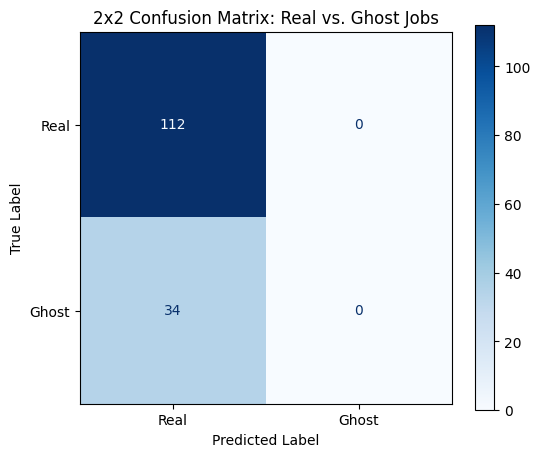

<ipython-input-13-29d1692b5570>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


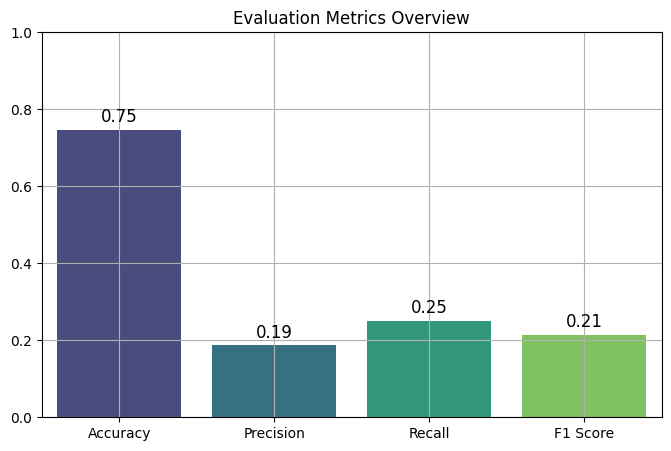

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating! Please wait!"):
        input_ids, attention_masks, labels, ghost_features = [x.to(device) for x in batch]

        batch_size = input_ids.size(0)
        ghost_features = ghost_features.view(batch_size, -1)

        if ghost_features.size(1) > 3:
            ghost_features = ghost_features[:, :3]
        elif ghost_features.size(1) < 3:
            pad_size = 3 - ghost_features.size(1)
            ghost_features = torch.cat([ghost_features, torch.zeros((batch_size, pad_size)).to(device)], dim=1)

        outputs = model(input_ids, attention_masks, ghost_features.float()).view(-1)
        preds = (outputs > 0.5).view(-1)
        labels = labels.view(-1)[:preds.shape[0]]

        all_preds.extend(preds.cpu().view(-1).numpy())
        all_labels.extend(labels.cpu().view(-1).numpy())

# Final prediction arrays
all_preds = np.array(all_preds).astype(int).flatten()
all_labels = np.array(all_labels).astype(int).flatten()

print("Unique values in labels:", np.unique(all_labels))
print("Unique values in preds:", np.unique(all_preds))

# Metric calculations
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"\nEvaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

#============
# 2x2 Confusion Matrix (Real vs. Ghost)
#============
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
print("\n2x2 Confusion Matrix (Real vs. Ghost):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Ghost"])
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("2x2 Confusion Matrix: Real vs. Ghost Jobs")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

#=========
# Bar Chart for Metrics
#=========
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.ylim(0, 1)
plt.title("Evaluation Metrics Overview")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.grid(True)
plt.show()